This notebook serves to update the figures in the paper

In [1]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 26}
mpl.rc('font', **font)

import numpy as np
from astropy.cosmology import Planck18, z_at_value
cosmo = Planck18
from scipy import integrate
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pickle, os

import h5py
import astropy.units as u

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


In [3]:
cosmo = Planck18# Define temporary cosmology for volume calculation
tot_sky = 41253. # Total square degrees in the sky

halo_model = "SMT"

mmin = 3 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

baryon_frac = 0.16 # from Planck18
c = 'orange'

In [4]:
cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
df0 = pd.read_csv('data/AC_117560.txt', names = cols, sep = '\s+')
df1 = pd.read_csv('data/AC_109760.txt', names = cols, sep = '\s+')
df2 = pd.read_csv('data/AC_55410.txt', names = cols, sep = '\s+') 

text_names = [r'$\mathrm{PRIMER-EXCELS-117560}$', r'$\mathrm{PRIMER-EXCELS-109760}$', r'$\mathrm{ZF-UDS-7329}$']
title_names = [r'$\mathrm{117560}$ ', r'$\mathrm{109760}$ ', r'$\mathrm{7329}$ ']

df0 = df0[df0['t']>0.15]
df1 = df1[df1['t']>0.15]
df2 = df2[df2['t']>0.15]
## transfer time into redshift - somewhat slow
z_AC0 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df0['t']])
z_AC1 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df1['t']])
z_AC2 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df2['t']])

In [5]:
def plotax(ax, zs, meds, sig1s, sig2s, sig3s = None, xlabel = True, d=0, ylabel = True, c='orange', survey = 'GS-55410 ', ty = 'SED-fitting', filter_size = 0.1, xmin = 3.2, log = False, leg = True, met = '', med_label = False):
    if log:
        meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )
    if med_label:
        ax.plot(zs, np.array(meds)-d, 'k--', linewidth=3, label = r'$\mathrm{Medians}$')
    else:
        ax.plot(zs, np.array(meds)-d, 'k--', linewidth=3)
        
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.3, label = r'1$\sigma$'+met)
    
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.2, label = r'2$\sigma$'+met)
    if np.any(sig3s):
        ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.1, label = r'3$\sigma$'+met)
    
    ax.grid(visible = True,alpha=0.3)
    if ty:
        ax.set(title = f'{survey}{ty}', ylim = (8.0,11.8), xlim = (xmin,12.4))
    else:
        ax.set(ylim = (8,11.8), xlim = (3.2,12.4))
        
    if ylabel:
        # ax.set(ylabel = r'$\mathrm{Stellar~mass}$ [$\mathrm{log}(M_*/M_{\odot})$]')
        ax.set(ylabel = r'$\mathrm{M_{*,max}}$ [$\mathrm{log}(M_*/M_{\odot})$]')

    if xlabel:
        ax.set(xlabel=r'$\mathrm{z}$')

    if leg:
        ax.legend(ncol=2, fontsize = 16, loc = 'lower left', columnspacing=0.5)

    return ax

/var/folders/7n/5d661fr13pz2l_3q38y38nz80000gn/T/ipykernel_4370/2399382009.py:3: RuntimeWarning: divide by zero encountered in log10
  meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )


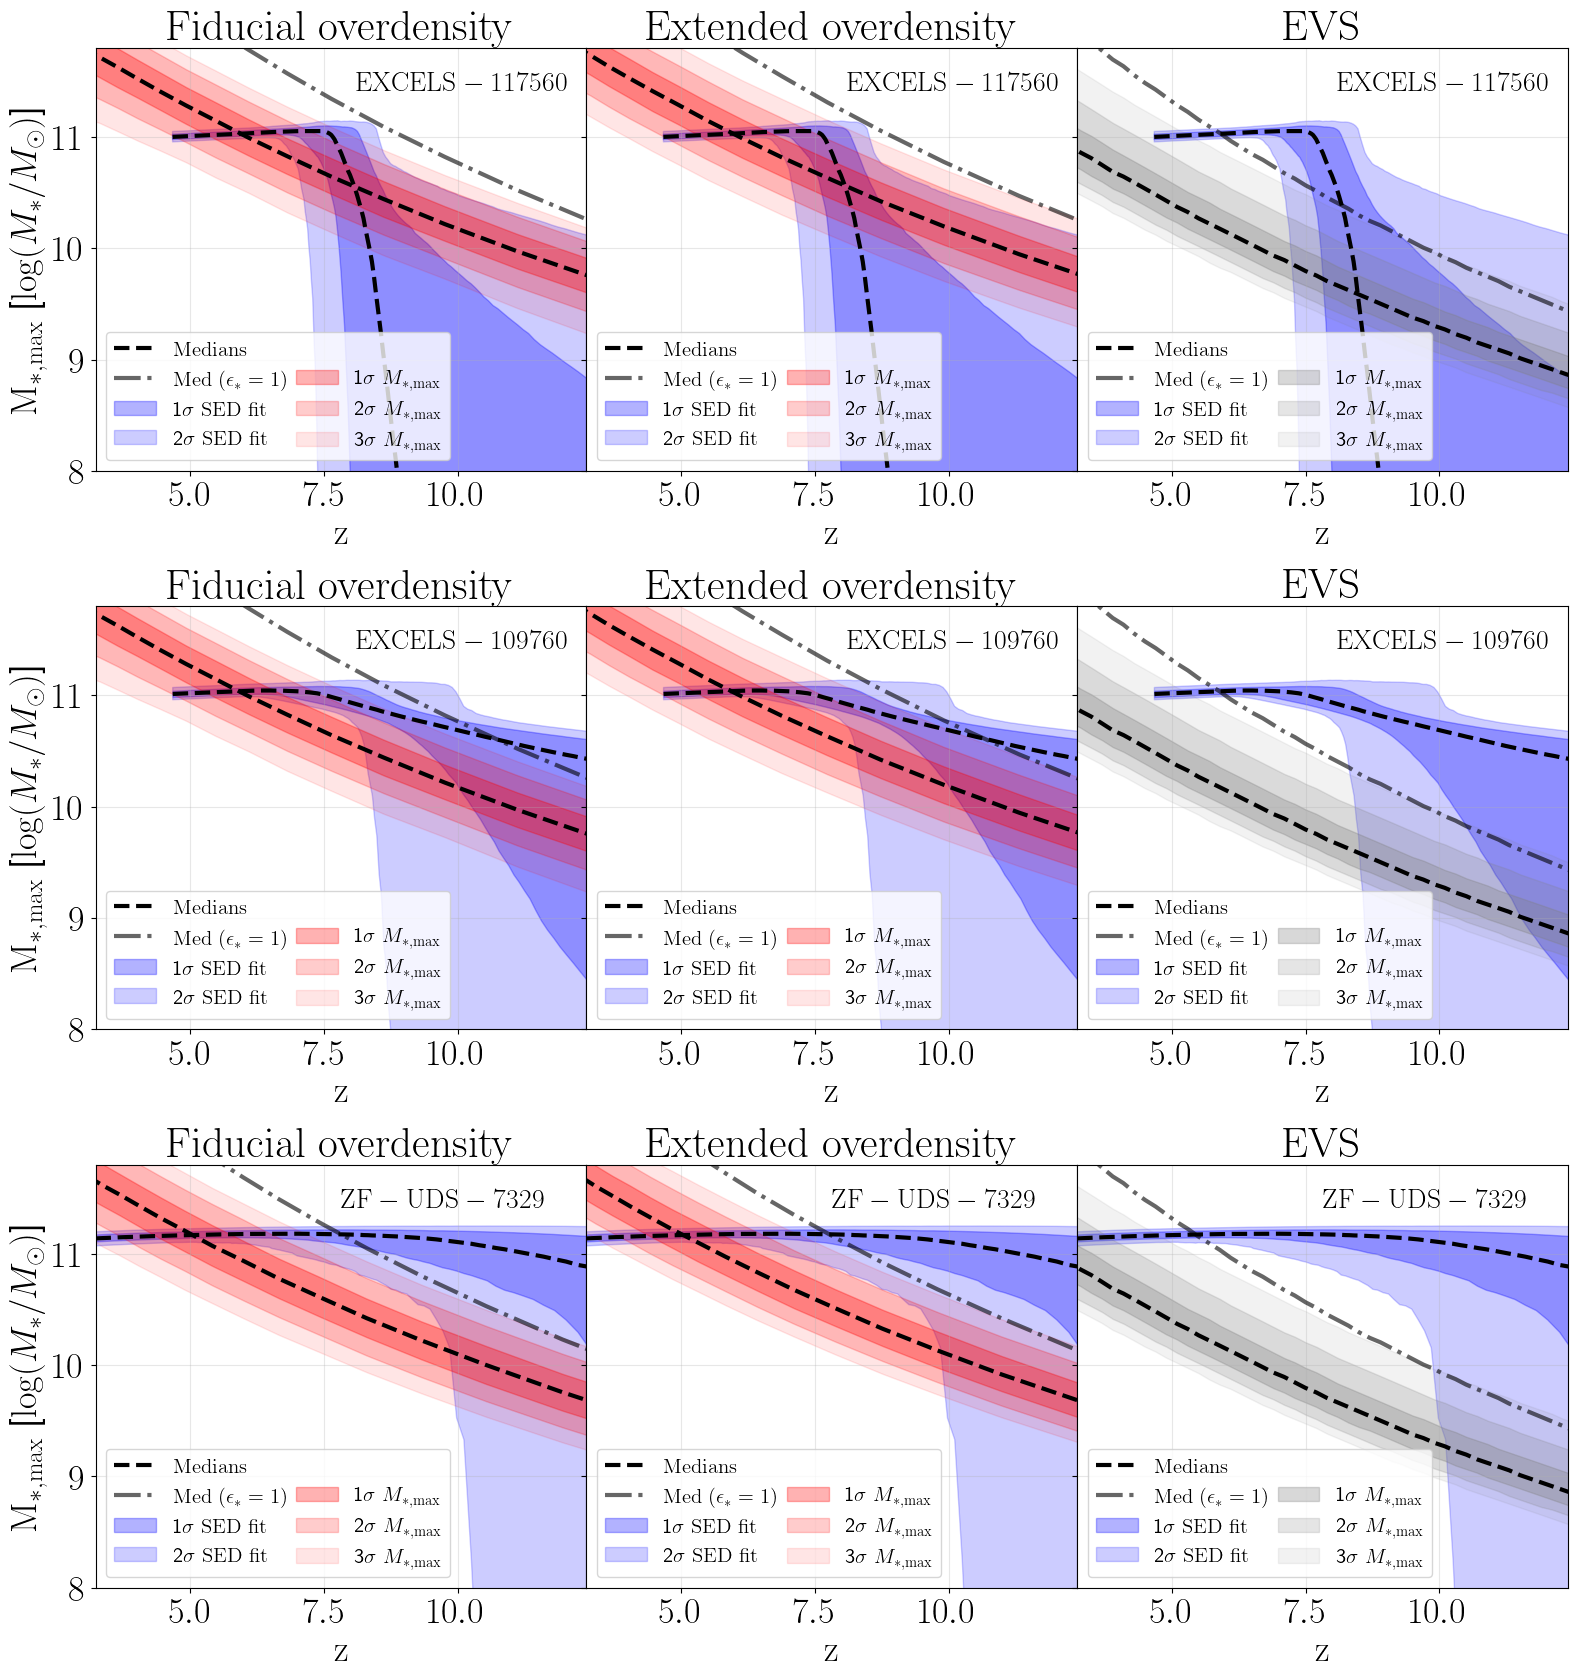

In [6]:
from evstats.evs import _apply_fsky
from evstats.stats import compute_conf_ints

text_names = [r'$\mathrm{EXCELS-117560}$', r'$\mathrm{EXCELS-109760}$', r'$\mathrm{ZF-UDS-7329}$']

fig, axss = plt.subplots(nrows = 3, ncols = 3, figsize = (19, 20), sharey = True)
axs = axss[0]
  
cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
plt.subplots_adjust(wspace = 0.0, hspace = 0.32) 
c_SED = 'b'
SEDlabel = r'$\mathrm{~SED~fit}$'
for idx, df, z_AC in zip([0, 1, 2], [df0, df1, df2], [z_AC0, z_AC1, z_AC2]):
    axs = axss[idx]
    plotax(axs[0], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = SEDlabel, med_label = True)
    plotax(axs[1], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = SEDlabel, med_label = True  )
    plotax(axs[2], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T,  ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = SEDlabel, med_label = True  )

cs = ['red', 'red', 'grey']
c_EVS = 'green'
titles = [[r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$'], 
          [r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$'], 
          [r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$']]
sbf1_title = r'$\mathrm{Med~(\epsilon_*=1)}$'
ODs = ['highz', 'highz', 'lowz']
sizes = ['small', 'big']
lw1 = 3
alpha1 = 0.6
d0 = 0.1

for j, OD in enumerate(ODs):
    axs = axss[j]
    for i, size in enumerate(sizes):
        
        with h5py.File(f'../evstats/data/{OD}_{size}_OD_fast_0.h5','r') as hf:
            log10m = hf['log10m'][:]+np.log10(0.15/0.1)
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
        zs = z
        meds_cdf = CIs[:,3]
        sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
        sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
        sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

        plotax(axs[i], zs, meds_cdf, sig1s, sig2s, sig3s = sig3s, d=0, ylabel = False, survey = titles[j][i], ty = ' ', c = cs[i], xmin = np.min(z_AC), met = r' $M_{*,\mathrm{max}}$')
        
        with h5py.File(f'../evstats/data/{OD}_{size}_OD_fast_0.25_SBF1.h5','r') as hf:
            log10m = hf['log10m'][:]
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
        zs = z
        meds_cdf_sbf1 = CIs[:,3]

        axs[i].plot(zs, np.array(meds_cdf_sbf1), 'k-.', alpha = alpha1, linewidth = lw1, label = sbf1_title)
        axs[i].legend(ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)
        legend = axs[i].get_legend()
        handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
        # Reorder: Move last element to second position
        handles = [handles[0], handles[-1]] + handles[1:-1]
        labels = [labels[0], labels[-1]] + labels[1:-1]
        handles.insert(4, plt.Line2D([0], [0], color='none'))
        labels.insert(4, "")
        
        axs[i].legend(handles, labels, ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)
        # axs[i].legend(ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)

    # with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    with h5py.File(os.path.expanduser('data/evs_all.h5'),'r') as hf:

        log10m_EVS = hf['log10m'][:]
        f = hf['f'][:]
        F = hf['F'][:]
        N = hf['N'][:]
        zs_EVS = hf['z'][:]

    whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
    survey_area = 160 * u.arcmin**2
    fsky = float(survey_area / whole_sky)
    phi_max0 = _apply_fsky(N, f, F, fsky)
    meds_cdf = []
    meds_cdf_sbf1 = []
    sig1s = []
    sig2s = []
    sig3s = []
    for k in range(len(zs_EVS)):

        z0 = zs_EVS[k]
        sbf = 0.1+0.02*(z0-4)
        
        M0 = log10m_EVS+np.log10(baryon_frac)
        cdf =  np.cumsum(phi_max0[k]*M0)/np.sum(phi_max0[k]*M0)
        cdf =  np.cumsum(phi_max0[k])/np.sum(phi_max0[k])

        meds_cdf_sbf1.append(M0[np.argmin(abs(cdf-0.5))])

        M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)
        cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
        meds_cdf.append(M1[np.argmin(abs(cdf-0.5))])
        sig1s.append([M1[np.argmin(abs(cdf-norm.cdf(-1)))], M1[np.argmin(abs(cdf-norm.cdf(1)))]])
        sig2s.append([M1[np.argmin(abs(cdf-norm.cdf(-2)))], M1[np.argmin(abs(cdf-norm.cdf(2)))]])
        sig3s.append([M1[np.argmin(abs(cdf-norm.cdf(-3)))], M1[np.argmin(abs(cdf-norm.cdf(3)))]])
    i = i+1
    plotax(axs[i], zs_EVS, meds_cdf, sig1s, sig2s, sig3s = sig3s, d=d0, ylabel = False, survey = r'$\mathrm{EVS}$', ty = ' ', c = cs[i], xmin = np.min(z_AC), met = r' $M_{*,\mathrm{max}}$')
    axs[i].plot(zs_EVS, np.array(meds_cdf_sbf1)-d0, 'k-.', alpha = alpha1, linewidth = lw1, label = sbf1_title)

    axs[i].legend(ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)
    legend = axs[i].get_legend()
    handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
    # Reorder: Move last element to second position
    handles = [handles[0], handles[-1]] + handles[1:-1]
    labels = [labels[0], labels[-1]] + labels[1:-1]
    handles.insert(4, plt.Line2D([0], [0], color='none'))
    labels.insert(4, "")
    
    axs[i].legend(handles, labels, ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)

for i in range(3):
    for j in range(3):
        name = text_names[i]
        x0 = 0.53
        if i == 2:
            x0 = 0.5
        axss[i][j].annotate(name, xy = (x0,0.9), xycoords = 'axes fraction', fontsize = 20)

# fig.suptitle(r'$\mathrm{Most~massive~galaxies~in~different~overdensities}$', y = 0.93)

In [7]:
# Adjust the bottom row (row index 2) downward
for ax in axss[2, :]:  # Iterate over all columns in the bottom row
    pos = ax.get_position()  # Get the original position
    ax.set_position([pos.x0, pos.y0 - 0.03, pos.width, pos.height])  # Shift downward

plt.show()

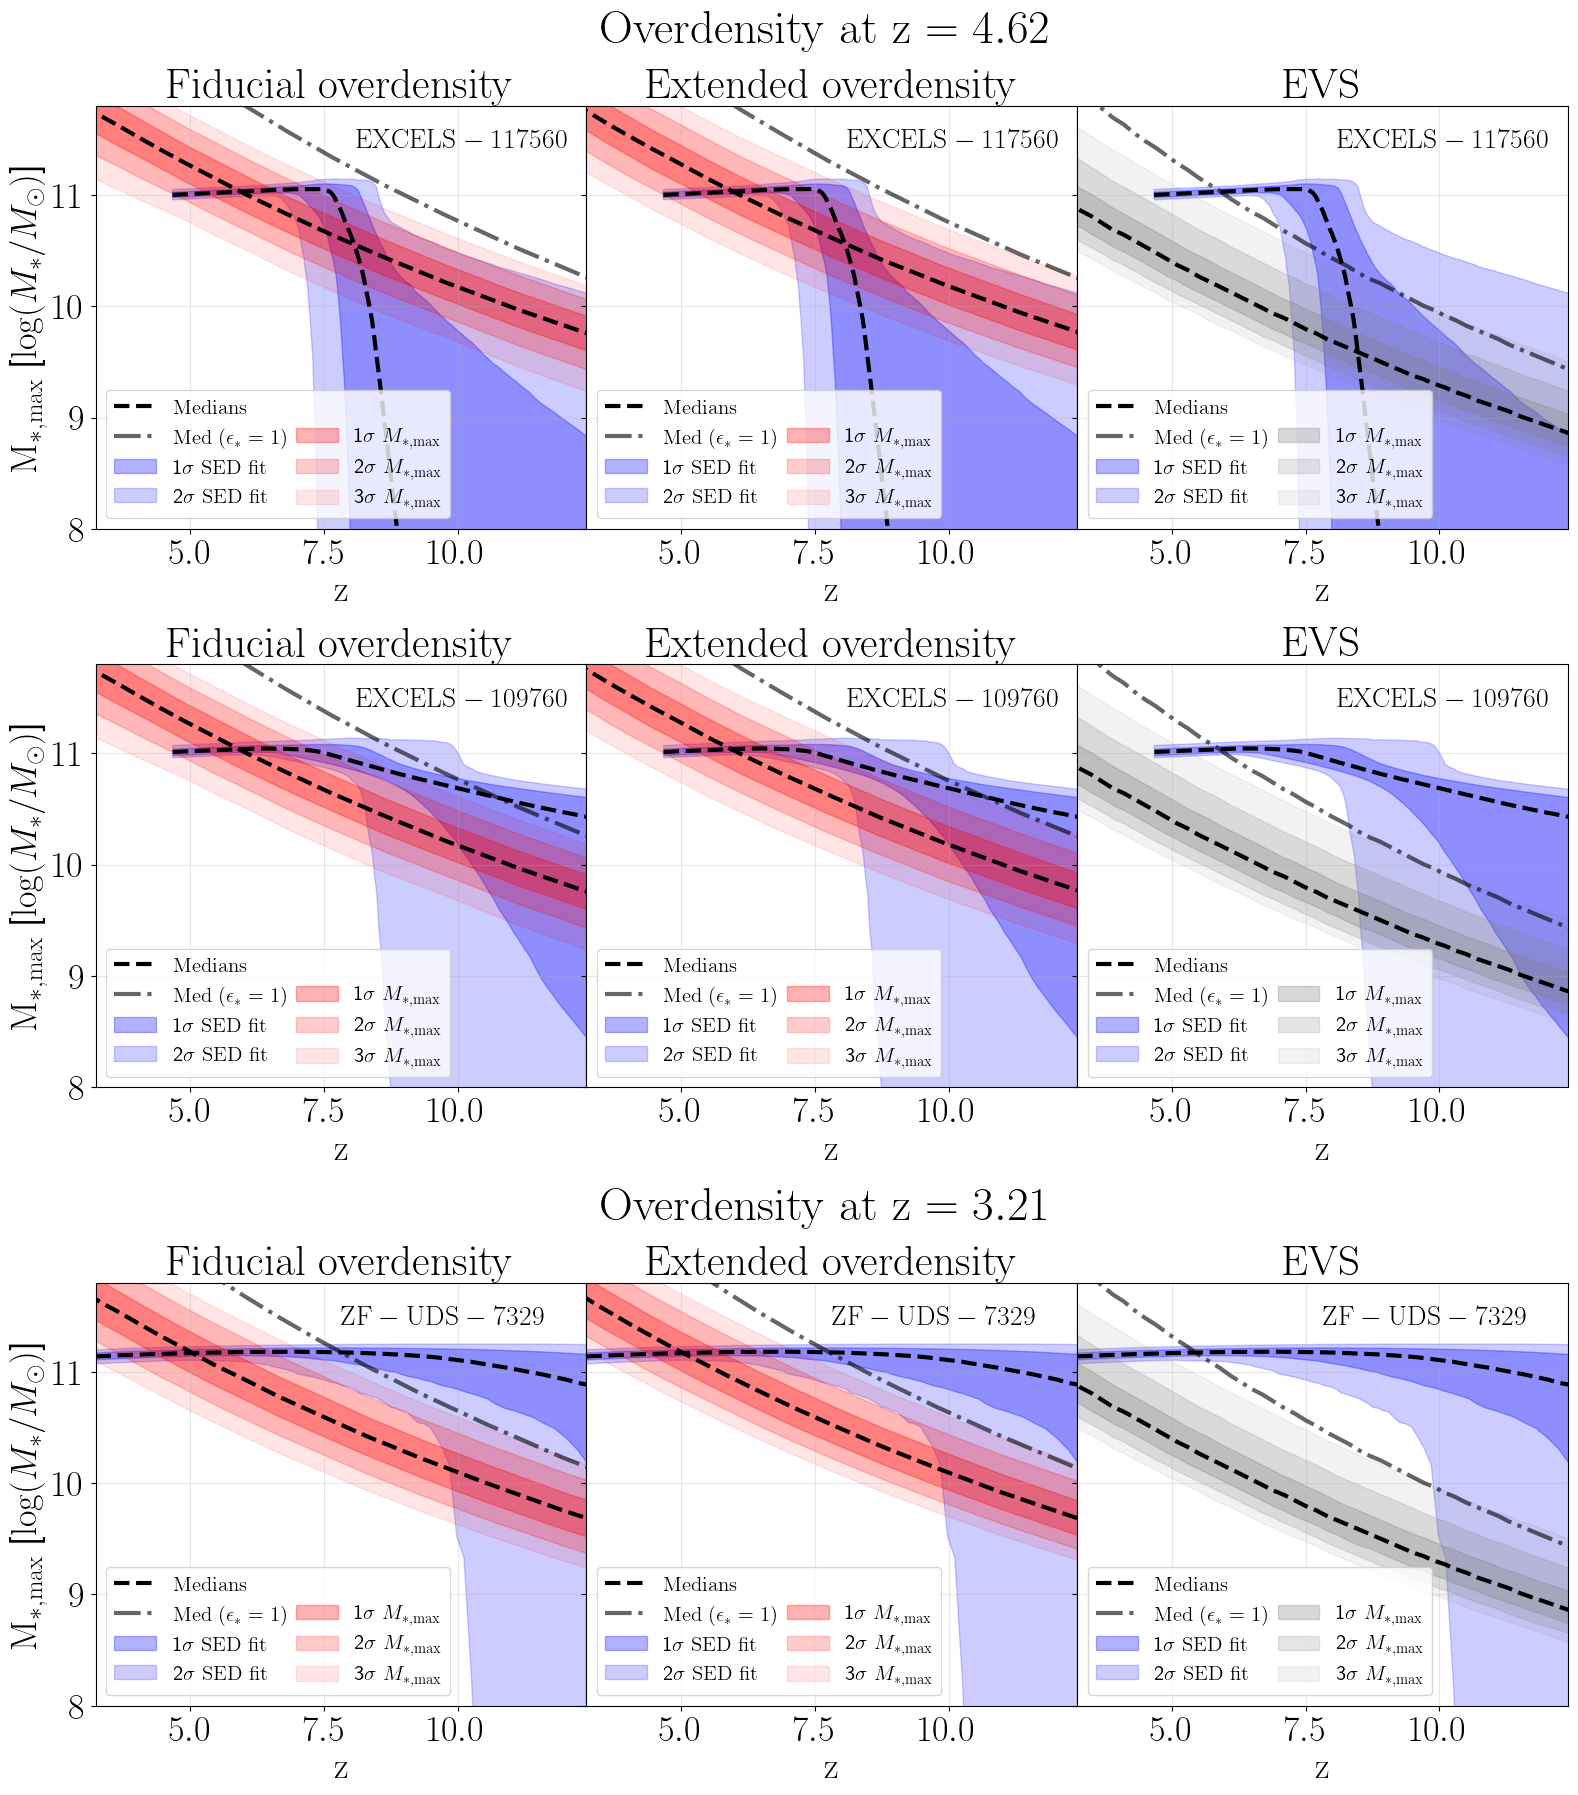

In [8]:
axss[0][1].annotate(r'$\mathrm{Overdensity~at~z = 4.62}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)
axss[2][1].annotate(r'$\mathrm{Overdensity~at~z = 3.21}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)

fig

In [9]:
fig.savefig('paper/combined_updated.png', bbox_inches = 'tight', dpi = 200)

Here we calculate the maximum discrepancy

In [50]:
df = df0
z_AC = z_AC0
r = 0.15
sig_mh_ms = 0.0
sbf_evs = 0.5
with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]+np.log10(r/0.1)
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 300 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):

    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.1 + 0.02 * (z0 - 4)
    else:
        sbf = sbf_evs
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(1)))]-med_model)
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

1.363729807445757
1.424605921706574


In [51]:
df = df1
z_AC = z_AC1

with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]+np.log10(r/0.1)
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 300 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):

    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.1 + 0.02 * (z0 - 4)
    else:
        sbf = sbf_evs
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(1)))]-med_model)
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

2.2633705789560583
2.511488911800862


In [52]:
df = df2
z_AC = z_AC2

with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]+np.log10(r/0.1)
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 300 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):

    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.1 + 0.02 * (z0 - 4)
    else:
        sbf = sbf_evs
    
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(1)))]-med_model)
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

2.939506790080848
3.489145817616266


In [53]:
sigs_OD = [2.94, 2.26, 1.36]
sigs_evs = [5.95, 5, 4.39]

sigs_OD = [2.57, 1.98, 1.16]
sigs_evs = [5.21, 4.29, 3.77]

sigs_OD = [1.52, 1.17, 0.65]
sigs_evs = [3.21, 2.52, 2.14]

sigs_OD = [0.1, 0.03, -0.16]
sigs_evs = [2.39, 1.00, 0.3]

np.linalg.norm(sigs_OD), np.linalg.norm(sigs_evs), -np.sqrt(-(sigs_OD[0]**2+sigs_OD[1]**2-sigs_OD[2]**2))

(0.19104973174542803, 2.608083587617544, -0.12124355652982141)

In [167]:
l = 1000
h = 1100
df.iloc[l:h]['m4']-df.iloc[l:h]['m2'], df.iloc[l:h]['m3']-df.iloc[l:h]['m2']
z_AC0[l:h], (df.iloc[l:h]['m2']-df.iloc[l:h]['m1'])/(df.iloc[l:h]['m2']-df.iloc[l:h]['m0'])

(array([5.8627394 , 5.87148364, 5.88030623, 5.88920835, 5.89819094,
        5.90725473, 5.9164009 , 5.92563034, 5.93494416, 5.9443431 ,
        5.95382848, 5.96340127, 5.97306245, 5.98281312, 5.99265451,
        6.00258764, 6.0126136 , 6.02273355, 6.03294883, 6.04326039,
        6.05366955, 6.06417771, 6.07478584, 6.08549528, 6.0963075 ,
        6.10722369, 6.11824514, 6.12937331, 6.14060955, 6.15195522,
        6.16341188, 6.17498084, 6.18666378, 6.19846204, 6.21037727,
        6.22241092, 6.23456466, 6.24684014, 6.25923895, 6.27176283,
        6.28441354, 6.29719268, 6.31010203, 6.32314354, 6.33631908,
        6.34963036, 6.36307934, 6.37666809, 6.39039852, 6.40427262,
        6.41829248, 6.43246029, 6.44677803, 6.46124805, 6.47587245,
        6.49065368, 6.50559382, 6.52069552, 6.53596095, 6.55139275,
        6.56699318, 6.58276523, 6.59871108, 6.61483376, 6.63113566,
        6.64761978, 6.66428899, 6.68114601, 6.69819399, 6.71543587,
        6.7328748 , 6.75051382, 6.76835631, 6.78

In [103]:
df.iloc[l:h]['m0'], df.iloc[l:h]['m2'], z_AC[l:h]

(1150    3.811176e-69
 1151    4.333263e-72
 1152    3.116576e-74
 1153    1.140436e-76
 1154    5.258992e-79
             ...     
 1216    0.000000e+00
 1217    0.000000e+00
 1218    0.000000e+00
 1219    0.000000e+00
 1220    0.000000e+00
 Name: m0, Length: 71, dtype: float64,
 1150    2.916554e+06
 1151    1.869537e+06
 1152    1.128257e+06
 1153    6.456556e+05
 1154    4.237772e+05
             ...     
 1216    1.227507e-18
 1217    1.777348e-19
 1218    2.449865e-20
 1219    3.000570e-21
 1220    3.450977e-22
 Name: m2, Length: 71, dtype: float64,
 array([4.83959244, 4.8534883 , 4.86754747, 4.88177277, 4.89616687,
        4.91073279, 4.92547329, 4.94039133, 4.95549004, 4.9707724 ,
        4.98624174, 5.00190127, 5.01775434, 5.03380424, 5.0500546 ,
        5.06650895, 5.08317103, 5.10004444, 5.11713317, 5.13444116,
        5.15197243, 5.16973104, 5.18772135, 5.20594769, 5.22441455,
        5.24312642, 5.26208814, 5.28130453, 5.30078038, 5.32052096,
        5.34053142, 5.36081713

Now let's make the distribution of masses given some number of sampled overdensities

In [182]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

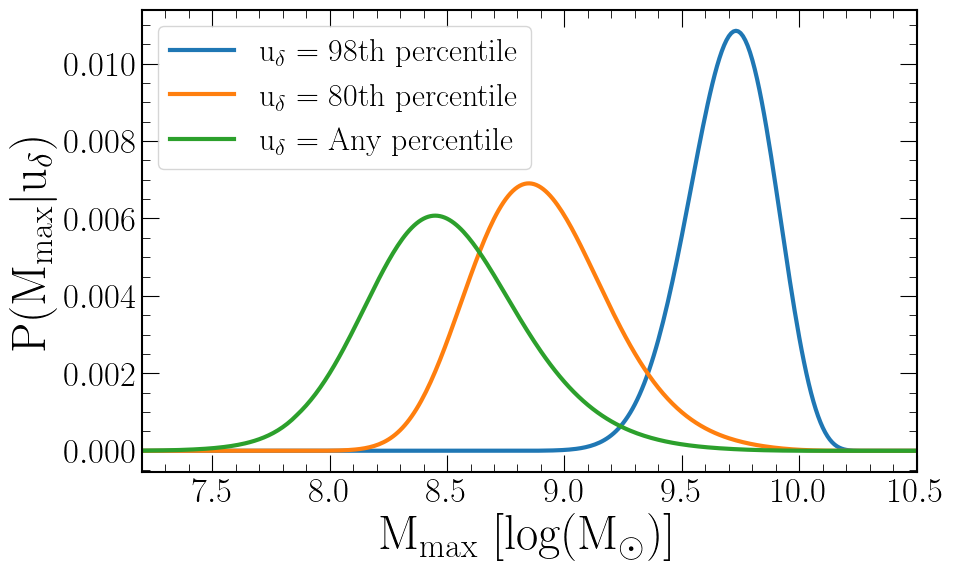

In [122]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{u}_{\delta}$'+' = '+sigl + ' percentile')
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
fig.savefig('paper/demo_dists.png', dpi = 200, bbox_inches = 'tight')

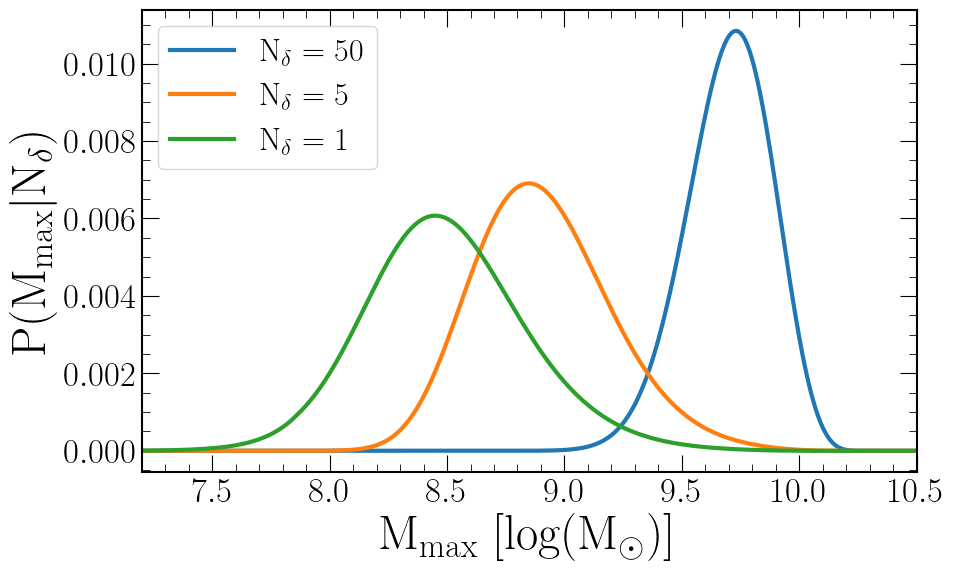

In [ ]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['50', '5', '1']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{N_{\delta}}$'+' = '+sigl)
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{N_{\delta}})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
fig.savefig('paper/demo_NOD.png', dpi = 200, bbox_inches = 'tight')

[5, 92, 173, 335, 497, 659, 821, 902, 980]


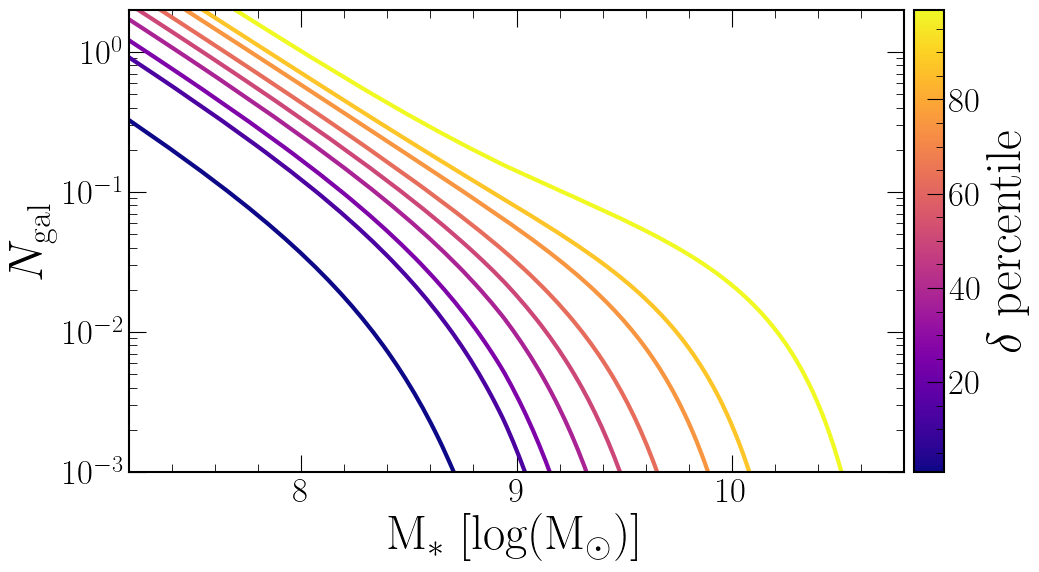

In [162]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
fig, ax = plt.subplots(figsize = (10,6))
nsamp = 81
zidx = 0
smf = smfs[zidx]
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-70::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
fig
fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

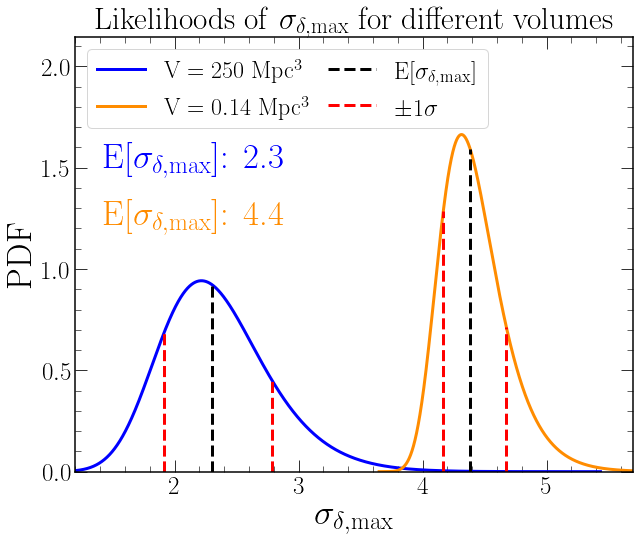

In [211]:
#  N_sky * f_sky * pow(F_sky, N_sky - 1.)

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
csmall = 'darkorange' 

l = 1e-5
fs = 35

N = 65
x = np.linspace(-7, 7, int(1e7))
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]

ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=250~Mpc^3}$')
ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.7), xycoords = 'axes fraction',\
            color = cbig, fontsize = fs)


N = 119145.0238214981
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=0.14~Mpc^3}$')

ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\mathrm{E[\sigma_{\delta,\mathrm{max}}]}$')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\pm 1\sigma$')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.set(xlim = (1.2, 5.7), ylim = (0, max(evs)*1.29), xlabel = r'$\sigma_{\delta, \mathrm{max}}$', \
       ylabel = r'$\mathrm{PDF}$', title = r'$\mathrm{Likelihoods~of~\sigma_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.57), xycoords = 'axes fraction',\
            color = csmall, fontsize = fs)

ax.legend(ncols = 2, loc = 'upper left', fontsize = 24, columnspacing = 0.8)
fig.savefig('paper/EVS_sigma.png', bbox_inches = 'tight', dpi = 200)

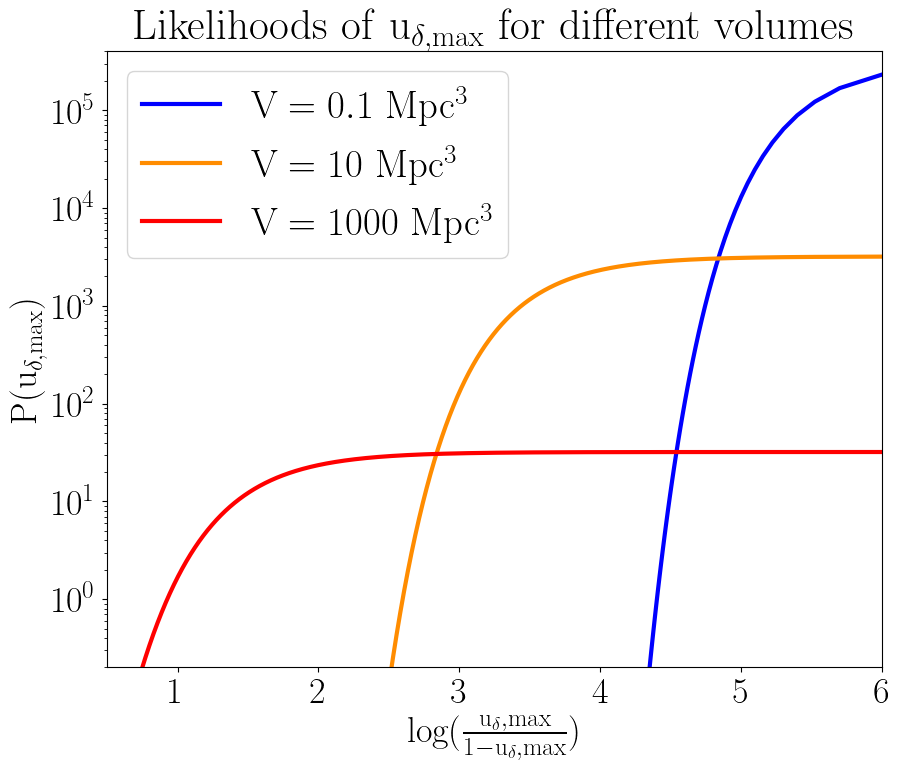

In [49]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 1e6
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

ax.plot(logit(x[evs>l]), evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=0.1~Mpc^3}$')


N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
ax.plot(logit(x[evs>l]), evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V=10~Mpc^3}$')

N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
ax.plot(logit(x[evs>l]), evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=1000~Mpc^3}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'log', ylim = (2e-1, 4e5), xlim = (0.5, np.log10(nsamp)), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig.savefig('paper/EVS_percentile_update.png', bbox_inches = 'tight', dpi = 200)